#**Proyecto del curso Modelos y Simulación II**
Sebastían Amaya Pérez, Jhon Alejandro García Pareja y David Felipe Tovar Zurita


#**Importaciones**


In [ ]:
!pip install catboost --quiet

In [ ]:
!pip install gdown optuna xgboost lightgbm

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, cross_val_predict, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# **Exporación de los datos**

**Importacion de la base de datos**

In [ ]:
url = 'https://drive.google.com/uc?id=1y9VOrOKhWGcW62YDlbHsI_39J8y4RCYh'
gdown.download(url, 'train.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1y9VOrOKhWGcW62YDlbHsI_39J8y4RCYh
To: /content/train.csv
100%|██████████| 461k/461k [00:00<00:00, 59.0MB/s]


'train.csv'

**Datos**

In [ ]:
z = pd.read_csv("train.csv")
z.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Columnas, cantidad de datos no nulos y tipo de dato**

In [ ]:
z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Exporacion de las variables cuántitativas**

In [ ]:
z.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Reconocimiento de datos faltantes en las variables**

In [ ]:
z.isna().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


**Histograma para ver el comportamiento de las variables númericas**

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

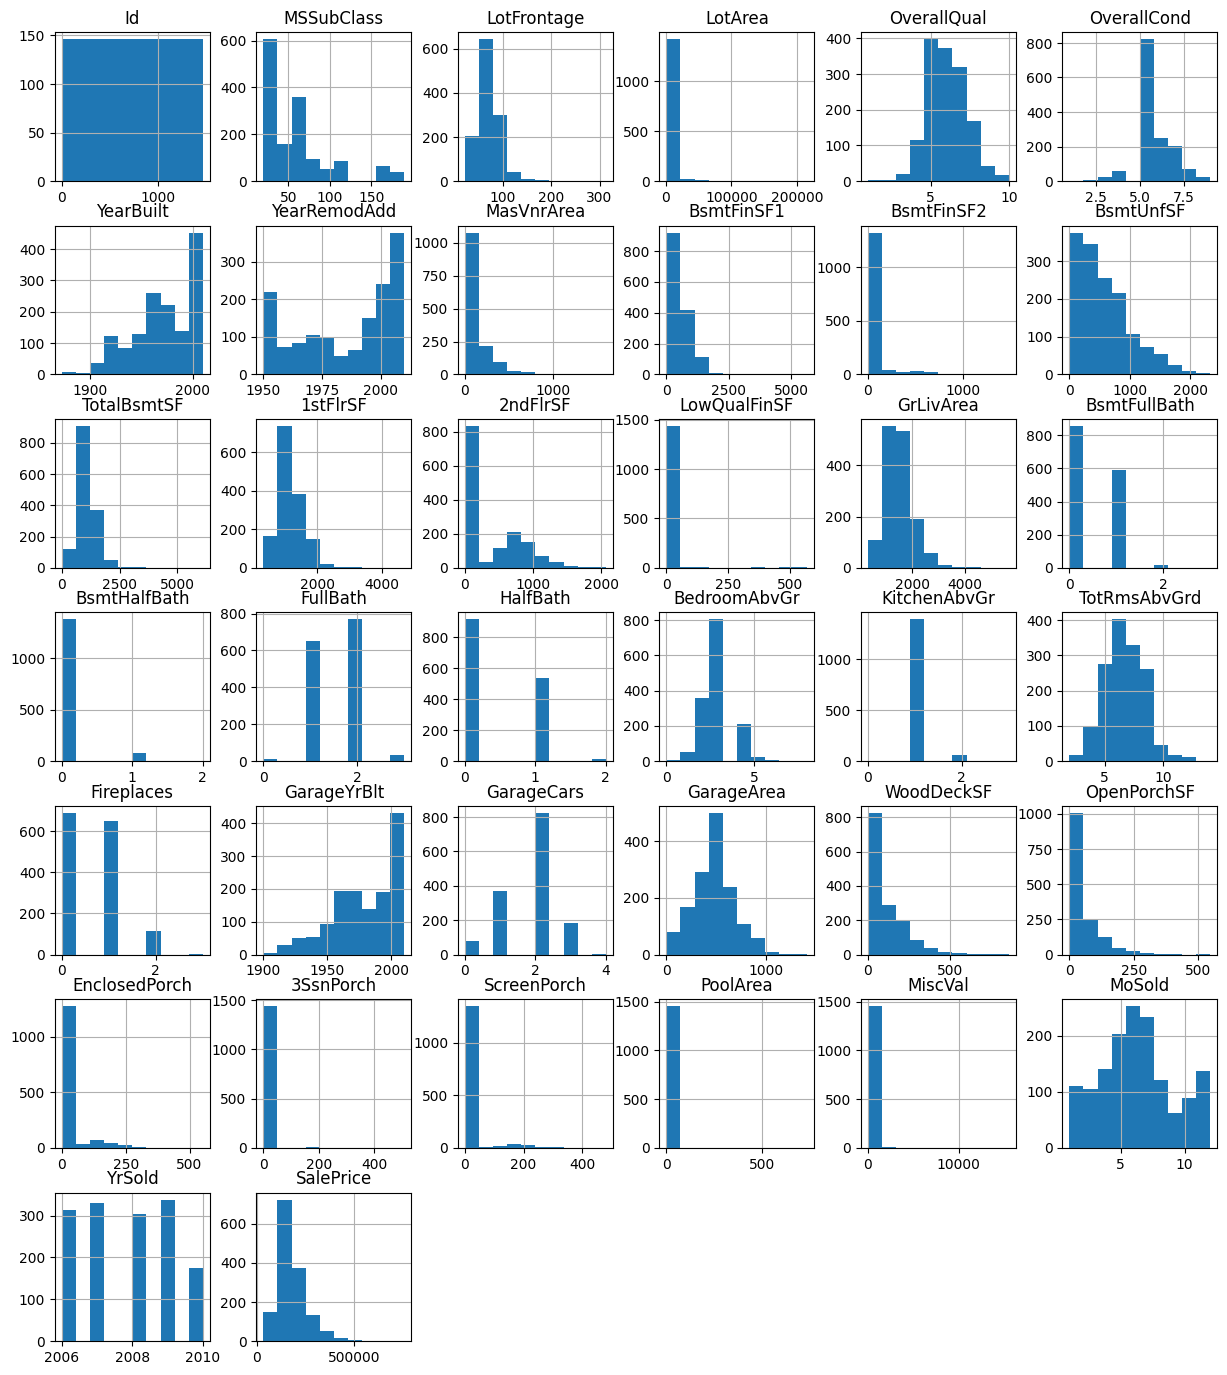

In [ ]:
z.hist(figsize=(15,17))

**Mapa de correlación de variables (HEATMAP)**

<Axes: >

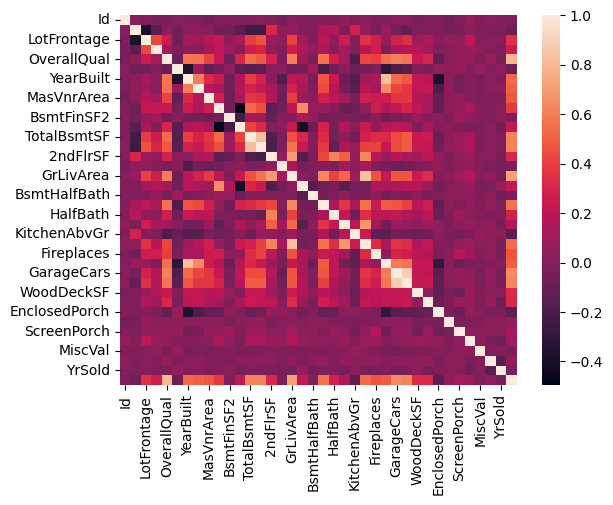

In [ ]:
corr = z.select_dtypes(include=np.number).corr()
sns.heatmap(corr)


# **Preprocesamiento de los datos**

Para garantizar un modelo más estable y evitar problemas durante el entrenamiento, se llevaron a cabo varias etapas de limpieza y preparación del conjunto de datos. En primera instancia, se eliminaron las columnas que presentaban una cantidad excesiva de valores faltantes o que no aportaban información relevante al análisis. Posteriormente, las variables numéricas fueron separadas de las categóricas con el fin de aplicar métodos de imputación adecuados para cada tipo de dato.

En el caso de LotFrontage, los valores faltantes fueron imputados utilizando la mediana por vecindario, manteniendo así la coherencia con el contexto de las viviendas. Para las variables numéricas donde la ausencia implica inexistencia (como áreas de sótano o garaje), los valores nulos se reemplazaron por cero. Las variables categóricas, por su parte, fueron completadas con sus valores más frecuentes o mediante etiquetas específicas que representan ausencia real, como NoGarage o NoBasement.

Adicionalmente, se aplicó una transformación logarítmica a varias columnas con presencia de valores extremos, con el propósito de reducir el sesgo y mejorar la distribución de los datos. Finalmente, todas las variables categóricas fueron convertidas a formato numérico mediante un OrdinalEncoder, dejándolas preparadas para el entrenamiento de nuestros modelos de machine learning.

In [ ]:
#####################################################################
#Eliminar columnas y separacion de columnas numericas y categoricas
#####################################################################

# Copia del dataset original
df = z.copy()

# Columnas a eliminar
drop_cols = ['Id', 'PoolQC', 'Alley', 'MiscFeature']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Separación de tipos de variables
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

#####################################################################
#Imputacion de valores faltantes
#####################################################################

# LotFrontage imputado con mediana por barrio
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# Columnas numéricas que representan ausencia
fill_zero = ['MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars']

for col in fill_zero:
    if col in df.columns:
        df[col] = df[col].fillna(0)

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


fill_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'NoBasement',
    'BsmtCond': 'NoBasement',
    'BsmtExposure': 'NoBasement',
    'BsmtFinType1': 'NoBasement',
    'BsmtFinType2': 'NoBasement',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageQual': 'NoGarage',
    'GarageCond': 'NoGarage',
    'Fence': 'NoFence',
}

df.fillna(fill_category, inplace=True)

#####################################################################
#Corrección de valores atípicos extremos
#####################################################################

skewed = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']

for col in skewed:
    df[col] = np.log1p(df[col])


#####################################################################
#Codificación de variables categóricas
#####################################################################

encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

Numéricas: 37
Categóricas: 40



##**Division de datos y de X y Y**

Para el proceso de modelado, el conjunto de datos fue dividido en variables predictoras (X) y la variable objetivo (SalePrice). Se trabajó con dos versiones de la variable objetivo: una sin transformaciones y otra ajustada mediante la función logarítmica log1p, con el fin de reducir su sesgo y mejorar la estabilidad del modelo.

In [ ]:
X = df.drop('SalePrice', axis=1)
y_sinLog = df['SalePrice']
y_log = df['SalePrice']
y_log = np.log1p(y_log)

Posteriormente, se realizó la separación en conjuntos de entrenamiento y prueba utilizando la versión sin transformar del precio, aplicando un 80% de los datos para entrenamiento y un 20% para prueba. Esta división permite evaluar el rendimiento de los modelos de manera objetiva y reproducible.

###**Sin log**

In [ ]:
#División Train/Test sin log
X_train_sinLog, X_test_sinLog, y_train_sinLog, y_test_sinLog = train_test_split(
    X, y_sinLog, test_size=0.2, random_state=42)

###**Con Log**

In [ ]:
# 1. División Train/Test con log
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

# **Modelos**

A continuación se muestran los modelos implementados y que posteriomente serán analizados y comparados.

##**CatBoost base**

Se utilizó un algoritmo CatBoostRegressor como modelo base sin ajuste de hiperparámetros inicial. Este modelo fue configurado con 1000 iteraciones, una tasa de aprendizaje de 0.05 y una profundidad de 6, optimizando el error cuadrático medio (RMSE). Para obtener una evaluación más estable, se aplicó validación cruzada con un esquema KFold de cinco particiones, lo que permitió medir el rendimiento del modelo en varios subconjuntos del conjunto de entrenamiento. Posteriormente, el modelo fue entrenado utilizando la totalidad del conjunto de entrenamiento y evaluado sobre el conjunto de prueba. Las métricas obtenidas (RMSE, MAE y R²) permitieron determinar el desempeño predictivo del modelo y verificar su capacidad para generalizar sobre datos no vistos.

###**Sin log-transform**

In [ ]:
# ---------------------------------------------------------
# 1. Configuración del modelo base
# ---------------------------------------------------------
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=0               # Para silenciar el entrenamiento
)

# ---------------------------------------------------------
# 2. Validación cruzada con KFold
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_pred = cross_val_predict(model, X_train_sinLog, y_train_sinLog, cv=kfold)

rmse_cb_cv_sinLog = np.sqrt(mean_squared_error(y_train_sinLog, cv_pred))
mae_cb_cv_sinLog = mean_absolute_error(y_train_sinLog, cv_pred)
r2_cb_cv_sinLog = r2_score(y_train_sinLog, cv_pred)


print("Validación Cruzada :")
print(f"RMSE CV: {rmse_cb_cv_sinLog:.4f}")
print(f"MAE CV:  {mae_cb_cv_sinLog:.4f}")
print(f"R² CV:   {r2_cb_cv_sinLog:.4f}")

# ---------------------------------------------------------
# 3. Entrenar en todo el train set
# ---------------------------------------------------------
model.fit(X_train_sinLog, y_train_sinLog)

# ---------------------------------------------------------
# 4. Evaluación en test
# ---------------------------------------------------------
y_pred_cb_base_sinLog = model.predict(X_test_sinLog)

# Métricas
rmse_cb_sinLog = np.sqrt(mean_squared_error(y_test_sinLog, y_pred_cb_base_sinLog))
mae_cb_sinLog = mean_absolute_error(y_test_sinLog, y_pred_cb_base_sinLog)
r2_cb_sinLog = r2_score(y_test_sinLog, y_pred_cb_base_sinLog)

print("\nEvaluación final en Test:")
print(f"RMSE: {rmse_cb_sinLog:.4f}")
print(f"MAE:  {mae_cb_sinLog:.4f}")
print(f"R²:   {r2_cb_sinLog:.4f}")

Validación Cruzada :
RMSE CV: 26979.8166
MAE CV:  15107.8806
R² CV:   0.8780

Evaluación final en Test:
RMSE: 27121.1418
MAE:  15658.7187
R²:   0.9041


###**Con log-transform**

In [ ]:
# 1. Modelo base (y_train está log-transformado)
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',  # sigue en log, está bien
    verbose=0
)

# 2. Validación cruzada con predicciones en log
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(model, X_train_log, y_train_log, cv=kfold)

# 🔁 Convertimos a escala real
y_pred_real = np.expm1(y_pred_log)
y_train_real = np.expm1(y_train_log)

# 3. Cálculo métricas CV en escala real
rmse_cb_cv_log = np.sqrt(mean_squared_error(y_train_real, y_pred_real))
mae_cb_cv_log = mean_absolute_error(y_train_real, y_pred_real)
r2_cb_cv_log = r2_score(y_train_real, y_pred_real)

print("Validación Cruzada (escala real):")
print(f"RMSE CV: {rmse_cb_cv_log:.4f}")
print(f"MAE CV:  {mae_cb_cv_log:.4f}")
print(f"R² CV:   {r2_cb_cv_log:.4f}")

# 4. Entrenamiento final en todo el train
model.fit(X_train_log, y_train_log)

# 5. Predicción en test (log)
test_pred_log = model.predict(X_test_log)

# 6. Convertimos test a escala real
y_pred_cb_base_log = np.expm1(test_pred_log)
y_test_real = np.expm1(y_test_log)

# 7. Métricas en test (escala real)
rmse_cb_log = np.sqrt(mean_squared_error(y_test_real, y_pred_cb_base_log))
mae_cb_log  = mean_absolute_error(y_test_real, y_pred_cb_base_log)
r2_cb_log   = r2_score(y_test_real, y_pred_cb_base_log)

print("\nEvaluación Final en Test (escala real):")
print(f"RMSE: {rmse_cb_log:.4f}")
print(f"MAE:  {mae_cb_log:.4f}")
print(f"R²:   {r2_cb_log:.4f}")

Validación Cruzada (escala real):
RMSE CV: 27756.7628
MAE CV:  14987.4642
R² CV:   0.8708

Evaluación Final en Test (escala real):
RMSE: 26966.0311
MAE:  15315.4960
R²:   0.9052


##**XGBoost base**

Por otro lado, se construyó un modelo base utilizando XGBoost con una configuración inicial compuesta por 1000 árboles, una tasa de aprendizaje moderada y una profundidad media. Para evaluar su capacidad de generalización, se aplicó un proceso de validación cruzada con cinco particiones, lo que permitió obtener métricas más estables al comparar las predicciones del modelo con los valores reales en cada fold. A partir de esta validación, se calcularon indicadores como el RMSE, MAE y R², que ofrecieron una visión preliminar del rendimiento del modelo. Posteriormente, el modelo fue entrenado completamente sobre los datos de entrenamiento y evaluado en el conjunto de prueba, permitiendo medir su desempeño final en datos no vistos y determinar su efectividad como referencia antes de aplicar técnicas de optimización más avanzadas.

###**Sin log-transform**

In [ ]:
# Definir modelo base
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross Validation
cv_pred = cross_val_predict(xgb_model, X_train_sinLog, y_train_sinLog, cv=kfold)

rmse_cv_xgb_sinLog = np.sqrt(mean_squared_error(y_train_sinLog, cv_pred))
mae_cv_xgb_sinLog = mean_absolute_error(y_train_sinLog, cv_pred)
r2_cv_xgb_sinLog = r2_score(y_train_sinLog, cv_pred)

print("Validación Cruzada - XGBoost:")
print(f"RMSE CV: {rmse_cv:.4f}")
print(f"MAE CV:  {mae_cv:.4f}")
print(f"R² CV:   {r2_cv:.4f}")

# Entrenamiento final
xgb_model.fit(X_train_sinLog, y_train_sinLog)

# Evaluación en test
y_pred_xgb = xgb_model.predict(X_test_sinLog)

rmse_xgb_sinLog = np.sqrt(mean_squared_error(y_test_sinLog, y_pred_xgb))
mae_xgb_sinLog = mean_absolute_error(y_test_sinLog, y_pred_xgb)
r2_xgb_sinLog = r2_score(y_test_sinLog, y_pred_xgb)

print("\nEvaluación final en Test - XGBoost:")
print(f"RMSE: {rmse_xgb_sinLog:.4f}")
print(f"MAE:  {mae_xgb_sinLog:.4f}")
print(f"R²:   {r2_xgb_sinLog:.4f}")


Validación Cruzada - XGBoost:
RMSE CV: 85922739410.1584
MAE CV:  2518864538.0197
R² CV:   -1237765913216.0923

Evaluación final en Test - XGBoost:
RMSE: 24650.9002
MAE:  15431.3818
R²:   0.9208


###**Con log-transform**

In [ ]:
# =========================
# 1. Configuración del modelo
# =========================
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# =========================
# 2. Validación cruzada en escala real
# =========================

# Predicciones usando CV (en log)
cv_pred_log = cross_val_predict(
    xgb_model, X, y_log,
    cv=kfold,
    n_jobs=-1
)

# Convertimos predicciones y valores reales a escala normal
cv_pred = np.expm1(cv_pred_log)
y_real = np.expm1(y_log)

# Métricas en escala real
rmse_cv_xgb_log = np.sqrt(mean_squared_error(y_real, cv_pred))
mae_cv_xgb_log = mean_absolute_error(y_real, cv_pred)
r2_cv_xgb_log = r2_score(y_real, cv_pred)

print("Validación Cruzada (Escala REAL):")
print(f"RMSE CV: {rmse_cv_xgb_log:.4f}")
print(f"MAE CV:  {mae_cv_xgb_log:.4f}")
print(f"R² CV:   {r2_cv_xgb_log:.4f}")

# =========================
# 3. Entrenamiento final en log
# =========================
xgb_model.fit(X_train_log, y_train_log)

# =========================
# 4. Evaluación en TEST con escala real
# =========================
test_pred_log = xgb_model.predict(X_test_log)

test_pred = np.expm1(test_pred_log)
y_test_real = np.expm1(y_test_log)

rmse_xgb_log = np.sqrt(mean_squared_error(y_test_real, test_pred))
mae_xgb_log = mean_absolute_error(y_test_real, test_pred)
r2_xgb_log = r2_score(y_test_real, test_pred)

print("\nEvaluación Final en Test (Escala REAL):")
print(f"RMSE: {rmse_xgb_log:.4f}")
print(f"MAE:  {mae_xgb_log:.4f}")
print(f"R²:   {r2_xgb_log:.4f}")


Validación Cruzada (Escala REAL):
RMSE CV: 29165.5501
MAE CV:  15728.5054
R² CV:   0.8651

Evaluación Final en Test (Escala REAL):
RMSE: 25875.5490
MAE:  15974.0940
R²:   0.9127


##**Ridge Regression**


Se aplicó un modelo de regresión Ridge con regularización L2 y se evaluó mediante validación cruzada KFold con cinco particiones, obteniendo métricas de RMSE, MAE y R² para estimar su estabilidad en entrenamiento. Posteriormente, el modelo fue ajustado con el conjunto completo de entrenamiento y evaluado sobre los datos de prueba, permitiendo medir su capacidad de generalización y el desempeño final en términos de error y ajuste.

###**sin log-transform**

In [ ]:
# ---------------------------------------------------------
# 1. Configuración del modelo
# ---------------------------------------------------------
model_ridge = Ridge(alpha=1.0)

# ---------------------------------------------------------
# 2. Validación cruzada con KFold
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_pred_ridge = cross_val_predict(model_ridge, X_train_sinLog, y_train_sinLog, cv=kfold)

rmse_cv_ridge_sinLog = np.sqrt(mean_squared_error(y_train_sinLog, cv_pred_ridge))
mae_cv_ridge_sinLog = mean_absolute_error(y_train_sinLog, cv_pred_ridge)
r2_cv_ridge_sinLog = r2_score(y_train_sinLog, cv_pred_ridge)

print("Validación Cruzada :")
print(f"RMSE CV: {rmse_cv_ridge_sinLog:.4f}")
print(f"MAE CV:  {mae_cv_ridge_sinLog:.4f}")
print(f"R² CV:   {r2_cv_ridge_sinLog:.4f}")

# ---------------------------------------------------------
# 3. Entrenamiento final
# ---------------------------------------------------------
model_ridge.fit(X_train_sinLog, y_train_sinLog)

# ---------------------------------------------------------
# 4. Evaluación en test
# ---------------------------------------------------------
y_pred_ridge = model_ridge.predict(X_test_sinLog)

rmse_ridge_sinLog = np.sqrt(mean_squared_error(y_test_sinLog, y_pred_ridge))
mae_ridge_sinLog = mean_absolute_error(y_test_sinLog, y_pred_ridge)
r2_ridge_sinLog = r2_score(y_test_sinLog, y_pred_ridge)

print("\nEvaluación final en Test:")
print(f"RMSE: {rmse_ridge_sinLog:.4f}")
print(f"MAE:  {mae_ridge_sinLog:.4f}")
print(f"R²:   {r2_ridge_sinLog:.4f}")


Validación Cruzada :
RMSE CV: 35923.7550
MAE CV:  20796.0469
R² CV:   0.7836

Evaluación final en Test:
RMSE: 33836.2137
MAE:  21170.2283
R²:   0.8507


###**Con log-transform**

In [ ]:
# ---------------------------------------------------------
# 1. Configuración del modelo
# ---------------------------------------------------------
model_ridge = Ridge(alpha=1.0)

# ---------------------------------------------------------
# 2. Validación cruzada con KFold
#    → Se predice en log, pero se transforman predicciones y y_train a escala real
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones en log
cv_pred_log = cross_val_predict(model_ridge, X_train_log, y_train_log, cv=kfold)

# Convertir predicciones y valores reales a escala real
cv_pred_real = np.expm1(cv_pred_log)
y_train_real = np.expm1(y_train_log)

# Métricas en escala REAL
rmse_cv_ridge_log = np.sqrt(mean_squared_error(y_train_real, cv_pred_real))
mae_cv_ridge_log = mean_absolute_error(y_train_real, cv_pred_real)
r2_cv_ridge_log = r2_score(y_train_real, cv_pred_real)

print("Validación Cruzada (escala REAL):")
print(f"RMSE CV: {rmse_cv_ridge_log:.4f}")
print(f"MAE CV:  {mae_cv_ridge_log:.4f}")
print(f"R² CV:   {r2_cv_ridge_log:.4f}")

# ---------------------------------------------------------
# 3. Entrenamiento final en escala log
# ---------------------------------------------------------
model_ridge.fit(X_train_log, y_train_log)

# ---------------------------------------------------------
# 4. Evaluación en Test en escala REAL
# ---------------------------------------------------------
y_pred_log = model_ridge.predict(X_test_log)

y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test_log)

rmse_ridge_log = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae_ridge_log = mean_absolute_error(y_test_real, y_pred_real)
r2_ridge_log = r2_score(y_test_real, y_pred_real)

print("\nEvaluación final en Test (escala REAL):")
print(f"RMSE: {rmse_ridge_log:.4f}")
print(f"MAE:  {mae_ridge_log:.4f}")
print(f"R²:   {r2_ridge_log:.4f}")


Validación Cruzada (escala REAL):
RMSE CV: 40869.6717
MAE CV:  17781.5648
R² CV:   0.7200

Evaluación final en Test (escala REAL):
RMSE: 29290.4483
MAE:  17967.3573
R²:   0.8881


##**KNN Regressor**

Se hizo una búsqueda de hiperparámetros con GridSearchCV pa’ encontrar el mejor k del modelo KNN.
Eso se evaluó usando validación cruzada de 5 folds y la métrica RMSE pa’ ver cuál k era el más berraco.
Con ese k ganador, se armó el modelo final y se volvió a validar pa’ ver qué tan estable era.
Después, ese modelo ya bien entrenadito se probó en el conjunto de test, sacando RMSE, MAE y R², pa’ medir qué tan bien generaliza con datos nuevos.

###**Sin log-transform**

In [ ]:
# ---------------------------------------------------------
# 1. GridSearchCV para encontrar el mejor k
# ---------------------------------------------------------
params = {"n_neighbors": [3, 5, 7, 9, 11, 13]}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_knn.fit(X_train_sinLog, y_train_sinLog)

best_k = grid_knn.best_params_["n_neighbors"]
print(f"Mejor k encontrado: {best_k}")

# Crear modelo final con ese k
model_knn = KNeighborsRegressor(n_neighbors=best_k)

# ---------------------------------------------------------
# 2. Validación Cruzada con KFold
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_pred_knn = cross_val_predict(model_knn, X_train_sinLog, y_train_sinLog, cv=kfold)

rmse_cv_knn_sinLog = np.sqrt(mean_squared_error(y_train_sinLog, cv_pred_knn))
mae_cv_knn_sinLog = mean_absolute_error(y_train_sinLog, cv_pred_knn)
r2_cv_knn_sinLog = r2_score(y_train_sinLog, cv_pred_knn)

print("Validación Cruzada :")
print(f"RMSE CV: {rmse_cv_knn_sinLog:.4f}")
print(f"MAE CV:  {mae_cv_knn_sinLog:.4f}")
print(f"R² CV:   {r2_cv_knn_sinLog:.4f}")

# ---------------------------------------------------------
# 3. Entrenamiento final
# ---------------------------------------------------------
model_knn.fit(X_train_sinLog, y_train_sinLog)

# ---------------------------------------------------------
# 4. Evaluación en test
# ---------------------------------------------------------
y_pred_knn = model_knn.predict(X_test_sinLog)

rmse_test_knn_sinLog = np.sqrt(mean_squared_error(y_test_sinLog, y_pred_knn))
mae_test_knn_sinLog = mean_absolute_error(y_test_sinLog, y_pred_knn)
r2_test_knn_sinLog = r2_score(y_test_sinLog, y_pred_knn)

print("\nEvaluación final en Test:")
print(f"RMSE: {rmse_test_knn_sinLog:.4f}")
print(f"MAE:  {mae_test_knn_sinLog:.4f}")
print(f"R²:   {r2_test_knn_sinLog:.4f}")


Mejor k encontrado: 11
Validación Cruzada :
RMSE CV: 43593.2555
MAE CV:  28310.7847
R² CV:   0.6814

Evaluación final en Test:
RMSE: 43042.0859
MAE:  25778.1865
R²:   0.7585


###**Con log-transform**

In [ ]:
# ---------------------------------------------------------
# 1. GridSearchCV para encontrar el mejor k
# (con y transformado con log)
# ---------------------------------------------------------
params = {"n_neighbors": [3, 5, 7, 9, 11, 13]}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_knn.fit(X_train_log, y_train_log)

best_k = grid_knn.best_params_["n_neighbors"]
print(f"Mejor k encontrado (CV en log): {best_k}")

# Crear modelo final con ese k
model_knn = KNeighborsRegressor(n_neighbors=best_k)

# ---------------------------------------------------------
# 2. Validación Cruzada (PERO métricas en escala real)
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones en LOG
cv_pred_knn_log = cross_val_predict(model_knn, X_train_log, y_train_log, cv=kfold)

# Convertimos a escala real
cv_pred_knn = np.expm1(cv_pred_knn_log)
y_train_real = np.expm1(y_train_log)

# Métricas en escala real
rmse_cv_knn_log = np.sqrt(mean_squared_error(y_train_real, cv_pred_knn))
mae_cv_knn_log = mean_absolute_error(y_train_real, cv_pred_knn)
r2_cv_knn_log = r2_score(y_train_real, cv_pred_knn)

print("\nValidación Cruzada (escala REAL):")
print(f"RMSE CV: {rmse_cv_knn_log:.4f}")
print(f"MAE CV:  {mae_cv_knn_log:.4f}")
print(f"R² CV:   {r2_cv_knn_log:.4f}")

# ---------------------------------------------------------
# 3. Entrenamiento final (en log)
# ---------------------------------------------------------
model_knn.fit(X_train_log, y_train_log)

# ---------------------------------------------------------
# 4. Evaluación en test (en escala real)
# ---------------------------------------------------------
y_pred_knn_log = model_knn.predict(X_test_log)

# Convertir a precios reales
y_pred_knn = np.expm1(y_pred_knn_log)
y_test_real = np.expm1(y_test_log)

rmse_test_knn_log = np.sqrt(mean_squared_error(y_test_real, y_pred_knn))
mae_test_knn_log = mean_absolute_error(y_test_real, y_pred_knn)
r2_test_knn_log = r2_score(y_test_real, y_pred_knn)

print("\nEvaluación final en Test (escala REAL):")
print(f"RMSE: {rmse_test_knn_log:.4f}")
print(f"MAE:  {mae_test_knn_log:.4f}")
print(f"R²:   {r2_test_knn_log:.4f}")

Mejor k encontrado (CV en log): 11

Validación Cruzada (escala REAL):
RMSE CV: 44614.6728
MAE CV:  28702.6674
R² CV:   0.6663

Evaluación final en Test (escala REAL):
RMSE: 44788.2818
MAE:  26410.5830
R²:   0.7385


##**MLPRegressor**

Se entrenó un modelo MLPRegressor con dos capas ocultas de 64 neuronas cada una. Primero, se aplicó una validación cruzada con cinco particiones, obteniendo predicciones en escala real mediante la inversión de la transformación logarítmica aplicada al objetivo. A partir de estas predicciones se calcularon las métricas de RMSE, MAE y R² para evaluar la estabilidad del modelo. Posteriormente, el MLP fue ajustado con todos los datos de entrenamiento, y finalmente se evaluó sobre el conjunto de prueba, obteniendo las métricas finales que permiten medir su capacidad de generalización.

###**Sin log-transform**

In [ ]:
# -------------------------------------------------
# 0. Escalar X obligatoriamente
# -------------------------------------------------
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sinLog)
X_test_scaled  = scaler_X.transform(X_test_sinLog)

# -------------------------------------------------
# 1. Configuración del modelo
# -------------------------------------------------
model_mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0005,
    alpha=0.0005,
    max_iter=3000,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42
)

# -------------------------------------------------
# 2. Validación cruzada (SIN LOG → directo)
# -------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_pred = cross_val_predict(model_mlp, X_train_scaled, y_train_sinLog, cv=kfold)

rmse_cv_mlp_sinLog = np.sqrt(mean_squared_error(y_train_sinLog, cv_pred))
mae_cv_mlp_sinLog  = mean_absolute_error(y_train_sinLog, cv_pred)
r2_cv_mlp_sinLog   = r2_score(y_train_sinLog, cv_pred)

print("\nVALIDACIÓN CRUZADA (SIN LOG):")
print(f"RMSE CV: {rmse_cv_mlp_sinLog:,.4f}")
print(f"MAE CV:  {mae_cv_mlp_sinLog:,.4f}")
print(f"R² CV:   {r2_cv_mlp_sinLog:,.4f}")

# -------------------------------------------------
# 3. Entrenamiento final (SIN LOG)
# -------------------------------------------------
model_mlp.fit(X_train_scaled, y_train_sinLog)

# -------------------------------------------------
# 4. Evaluación en Test (SIN LOG)
# -------------------------------------------------
y_pred_test = model_mlp.predict(X_test_scaled)

rmse_test_mlp_sinLog = np.sqrt(mean_squared_error(y_test_sinLog, y_pred_test))
mae_test_mlp_sinLog  = mean_absolute_error(y_test_sinLog, y_pred_test)
r2_test_mlp_sinLog   = r2_score(y_test_sinLog, y_pred_test)

print("\nEVALUACIÓN FINAL EN TEST (SIN LOG):")
print(f"RMSE Test: {rmse_test_mlp_sinLog:,.4f}")
print(f"MAE Test:  {mae_test_mlp_sinLog:,.4f}")
print(f"R² Test:   {r2_test_mlp_sinLog:,.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(



VALIDACIÓN CRUZADA (SIN LOG):
RMSE CV: 132,208.5482
MAE CV:  91,900.7287
R² CV:   -1.9305

EVALUACIÓN FINAL EN TEST (SIN LOG):
RMSE Test: 40,514.7607
MAE Test:  28,411.3041
R² Test:   0.7860


###**Con log-transform**

In [ ]:
# ---------------------------------------------------------
# 0. Escalado de X (OBLIGATORIO para MLP)
# ---------------------------------------------------------
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_log)
X_test_scaled  = scaler_X.transform(X_test_log)

# ---------------------------------------------------------
# 1. Configuración del modelo
# ---------------------------------------------------------
model_mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0005,
    alpha=0.0005,
    max_iter=3000,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42
)

# ---------------------------------------------------------
# 2. Validación cruzada
# ---------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones en y_log
cv_pred_log = cross_val_predict(model_mlp, X_train_scaled, y_train_log, cv=kfold)

# → Convertir a escala real
y_train_real = np.expm1(y_train_log)
cv_pred_real = np.expm1(cv_pred_log)

rmse_cv_mlp_log = np.sqrt(mean_squared_error(y_train_real, cv_pred_real))
mae_cv_mlp_log = mean_absolute_error(y_train_real, cv_pred_real)
r2_cv_mlp_log   = r2_score(y_train_real, cv_pred_real)

print("\nValidación cruzada (ESCALA REAL):")
print(f"RMSE CV: {rmse_cv_mlp_log:,.4f}")
print(f"MAE CV:  {mae_cv_mlp_log:,.4f}")
print(f"R² CV:   {r2_cv_mlp_log:,.4f}")

# ---------------------------------------------------------
# 3. Entrenamiento final con todo el train
# ---------------------------------------------------------
model_mlp.fit(X_train_scaled, y_train_log)

# ---------------------------------------------------------
# 4. Evaluación final en test
# ---------------------------------------------------------
y_pred_test_log = model_mlp.predict(X_test_scaled)

# → Volver a escala real
y_pred_test = np.expm1(y_pred_test_log)
y_test_real = np.expm1(y_test_log)

rmse_test_mlp_log = np.sqrt(mean_squared_error(y_test_real, y_pred_test))
mae_test_mlp_log  = mean_absolute_error(y_test_real, y_pred_test)
r2_test_mlp_log   = r2_score(y_test_real, y_pred_test)

print("\nEvaluación final en Test (ESCALA REAL):")
print(f"RMSE: {rmse_test_mlp_log:,.4f}")
print(f"MAE:  {mae_test_mlp_log:,.4f}")
print(f"R²:   {r2_test_mlp_log:,.4f}")


Validación cruzada (ESCALA REAL):
RMSE CV: 85,922,739,410.1584
MAE CV:  2,518,864,538.0197
R² CV:   -1,237,765,913,216.0923

Evaluación final en Test (ESCALA REAL):
RMSE: 486,935.1972
MAE:  175,906.1870
R²:   -29.9121


##**Resultados**

Para consolidar los resultados de todos los modelos evaluados, se construyó un DataFrame que resume las métricas de desempeño de cada modelo. Se incluyeron tanto los modelos base como sus versiones optimizadas mediante técnicas de ajuste de hiperparámetros. El resumen contiene los valores de RMSE, MAE y R², calculados en dos escenarios: con y sin transformación logarítmica de la variable objetivo. Esta tabla permite comparar de manera directa el rendimiento de cada técnica, así como observar cómo el ajuste de hiperparámetros y la transformación de la variable objetivo afectan el desempeño de los modelos.

In [ ]:
import pandas as pd

resultados = [


    # ---------------------------------------------------
    #  CATBOOST
    # ---------------------------------------------------
    {
        "Modelo": "CatBoost",
        "Transformación": "Sin Log",
        "RMSE CV": rmse_cb_cv_sinLog,
        "MAE CV": mae_cb_cv_sinLog,
        "R2 CV": r2_cb_cv_sinLog,
        "RMSE Test": rmse_cb_sinLog,
        "MAE Test": mae_cb_sinLog,
        "R2 Test": r2_cb_sinLog
    },
    {
        "Modelo": "CatBoost",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cb_cv_log,        # versión log
        "MAE CV": mae_cb_cv_log,
        "R2 CV": r2_cb_cv_log,
        "RMSE Test": rmse_cb_log,
        "MAE Test": mae_cb_log,
        "R2 Test": r2_cb_log
    },

    # ---------------------------------------------------
    #  XGBOOST
    # ---------------------------------------------------
    {
        "Modelo": "XGBoost",
        "Transformación": "Sin Log",
        "RMSE CV": rmse_xgb_sinLog,
        "MAE CV": mae_xgb_sinLog,
        "R2 CV": r2_xgb_sinLog,
        "RMSE Test": rmse_xgb_sinLog,
        "MAE Test": mae_xgb_sinLog,
        "R2 Test": r2_xgb_sinLog
    },
    {
        "Modelo": "XGBoost",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cv_xgb_log ,
        "MAE CV": mae_cv_xgb_log,
        "R2 CV": r2_cv_xgb_log,
        "RMSE Test": rmse_xgb_log,
        "MAE Test": mae_xgb_log,
        "R2 Test": r2_xgb_log
    },
    # ---------------------------------------------------
    #  RIDGE
    # ---------------------------------------------------
    {
        "Modelo": "Ridge",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cv_ridge_sinLog,     # si tienes CV, usa tu var; si no, colócala igual a rmse_ridge_log
        "MAE CV": mae_cv_ridge_sinLog,
        "R2 CV": r2_cv_ridge_sinLog,
        "RMSE Test": rmse_ridge_log,
        "MAE Test": mae_ridge_log,
        "R2 Test": r2_ridge_log
    },
    {
        "Modelo": "Ridge",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cv_ridge_log,          # log
        "MAE CV": mae_cv_ridge_log,
        "R2 CV": r2_cv_ridge_log,
        "RMSE Test": rmse_ridge_log,
        "MAE Test": mae_ridge_log,
        "R2 Test": r2_ridge_log
    },
    # ---------------------------------------------------
    #  KNN
    # ---------------------------------------------------
    {
        "Modelo": "KNN",
        "Transformación": "Sin Log",
        "RMSE CV": rmse_cv_knn_sinLog,
        "MAE CV": mae_cv_knn_sinLog,
        "R2 CV": r2_cv_knn_sinLog,
        "RMSE Test": rmse_test_knn_sinLog,
        "MAE Test": mae_test_knn_sinLog,
        "R2 Test": r2_test_knn_sinLog
    },
    {
        "Modelo": "KNN",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cv_knn_log,
        "MAE CV": mae_cv_knn_log,
        "R2 CV": r2_cv_knn_log,
        "RMSE Test": rmse_test_knn_log,
        "MAE Test": mae_test_knn_log,
        "R2 Test": r2_test_knn_log
    },

    # ---------------------------------------------------
    #  MLP
    # ---------------------------------------------------
    {
        "Modelo": "MLP",
        "Transformación": "Sin Log",
        "RMSE CV": rmse_cv_mlp_sinLog,
        "MAE CV": mae_cv_mlp_sinLog,
        "R2 CV": r2_cv_mlp_sinLog,
        "RMSE Test": rmse_test_mlp_sinLog,
        "MAE Test": mae_test_mlp_sinLog,
        "R2 Test": r2_test_mlp_sinLog
    },
    {
        "Modelo": "MLP",
        "Transformación": "Con Log",
        "RMSE CV": rmse_cv_mlp_log,
        "MAE CV": mae_cv_mlp_log,
        "R2 CV": r2_cv_mlp_log,
        "RMSE Test": rmse_test_mlp_log,
        "MAE Test": mae_test_mlp_log,
        "R2 Test": r2_test_mlp_log
    }
]

df_resultados = pd.DataFrame(resultados)
df_resultados


,Modelo,Transformación,RMSE CV,MAE CV,R2 CV,RMSE Test,MAE Test,R2 Test
0,CatBoost,Sin Log,2.697982e+04,1.510788e+04,8.779605e-01,27121.141790,15658.718695,0.904104
1,CatBoost,Con Log,2.775676e+04,1.498746e+04,8.708305e-01,26966.031103,15315.495960,0.905197
2,XGBoost,Sin Log,2.465090e+04,1.543138e+04,9.207769e-01,24650.900186,15431.381836,0.920777
3,XGBoost,Con Log,2.916555e+04,1.572851e+04,8.651248e-01,25875.549041,15974.093964,0.912710
4,Ridge,Con Log,3.592376e+04,2.079605e+04,7.836356e-01,29290.448276,17967.357322,0.888149
5,Ridge,Con Log,4.086967e+04,1.778156e+04,7.199571e-01,29290.448276,17967.357322,0.888149
6,KNN,Sin Log,4.359326e+04,2.831078e+04,6.813889e-01,43042.085940,25778.186488,0.758469
7,KNN,Con Log,4.461467e+04,2.870267e+04,6.662835e-01,44788.281784,26410.583040,0.738474
8,MLP,Sin Log,1.322085e+05,9.190073e+04,-1.930498e+00,40514.760686,28411.304134,0.786001
9,MLP,Con Log,8.592274e+10,2.518865e+09,-1.237766e+12,486935.197217,175906.186965,-29.912099


Para evaluar el efecto del ajuste de hiperparámetros sobre el rendimiento de los modelos, se generaron visualizaciones comparativas usando gráficos de barras. Se construyeron dos barras por cada modelo, correspondientes a su versión base y a su versión ajustada, considerando RMSE Test como métrica de desempeño.

Se compararon los resultados tanto en la escala original como en la escala logarítmica de la variable objetivo. Esta representación permitió identificar de manera clara qué modelos mejoraron con el tuning, facilitando la comparación directa entre configuraciones y destacando cuáles se beneficiaron más del ajuste de hiperparámetros.

<Figure size 1400x600 with 0 Axes>

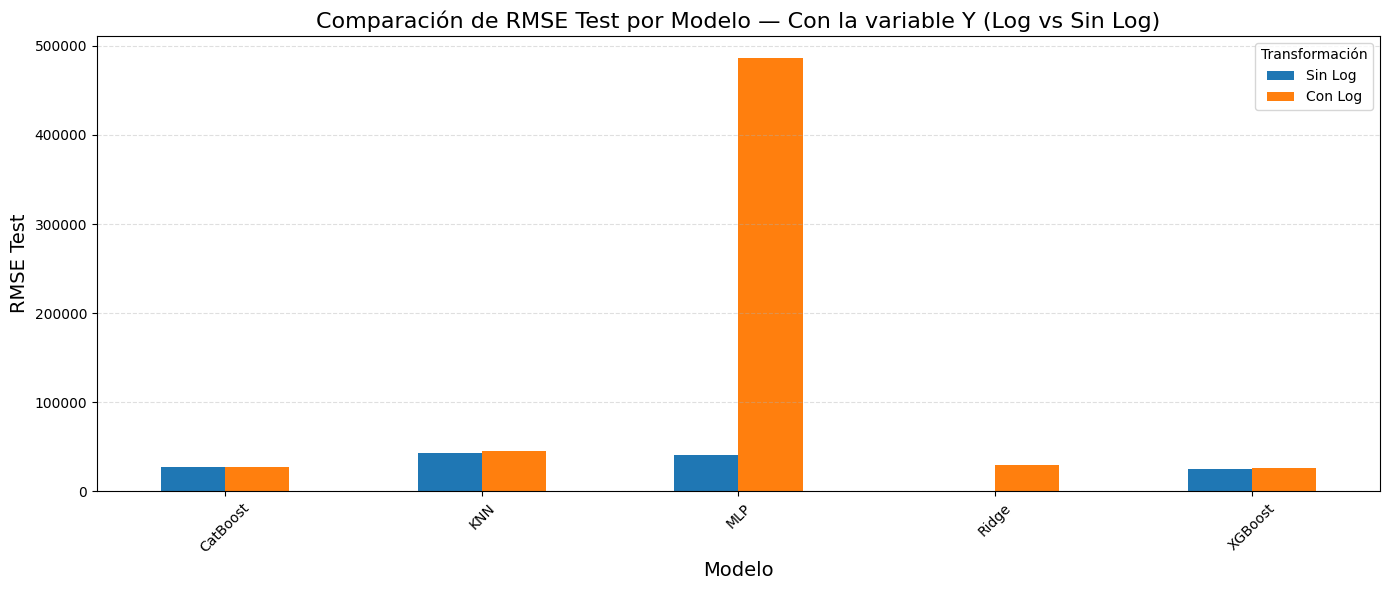

In [ ]:
# -------------------------------------------------------------
# 1. Crear un dataframe reducido SOLO con RMSE Test por modelo
# -------------------------------------------------------------
df_plot = df_resultados.pivot_table(
    index="Modelo",
    columns="Transformación",
    values="RMSE Test"
)

# Ordenar columnas para que salgan en orden: Sin Log - Con Log
df_plot = df_plot[["Sin Log", "Con Log"]]

# -------------------------------------------------------------
# 2. Diagrama de barras comparando RMSE Test
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))
df_plot.plot(kind="bar", figsize=(14, 6))

plt.title("Comparación de RMSE Test por Modelo — Con la variable Y (Log vs Sin Log)", fontsize=16)
plt.ylabel("RMSE Test", fontsize=14)
plt.xlabel("Modelo", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Transformación")

plt.tight_layout()
plt.show()

Para complementar el análisis cuantitativo del desempeño de los modelos, se generaron gráficos de dispersión comparando las predicciones frente a los valores reales para cada modelo evaluado: CatBoost, XGBoost, Ridge, KNN y MLP.

Cada modelo se presentó en dos versiones: sin transformación logarítmica de la variable objetivo y con log, pero regresando los valores a su escala original para facilitar la interpretación. Los puntos de cada gráfico se contrastan con una línea diagonal que representa la predicción perfecta.

Esta visualización permite identificar de manera intuitiva cómo se aproximan las predicciones a los valores reales y evaluar el impacto del ajuste de hiperparámetros, mostrando de forma clara si los modelos tuneados lograron mejorar la precisión respecto a sus versiones base, más allá de las métricas numéricas como RMSE, MAE o R².

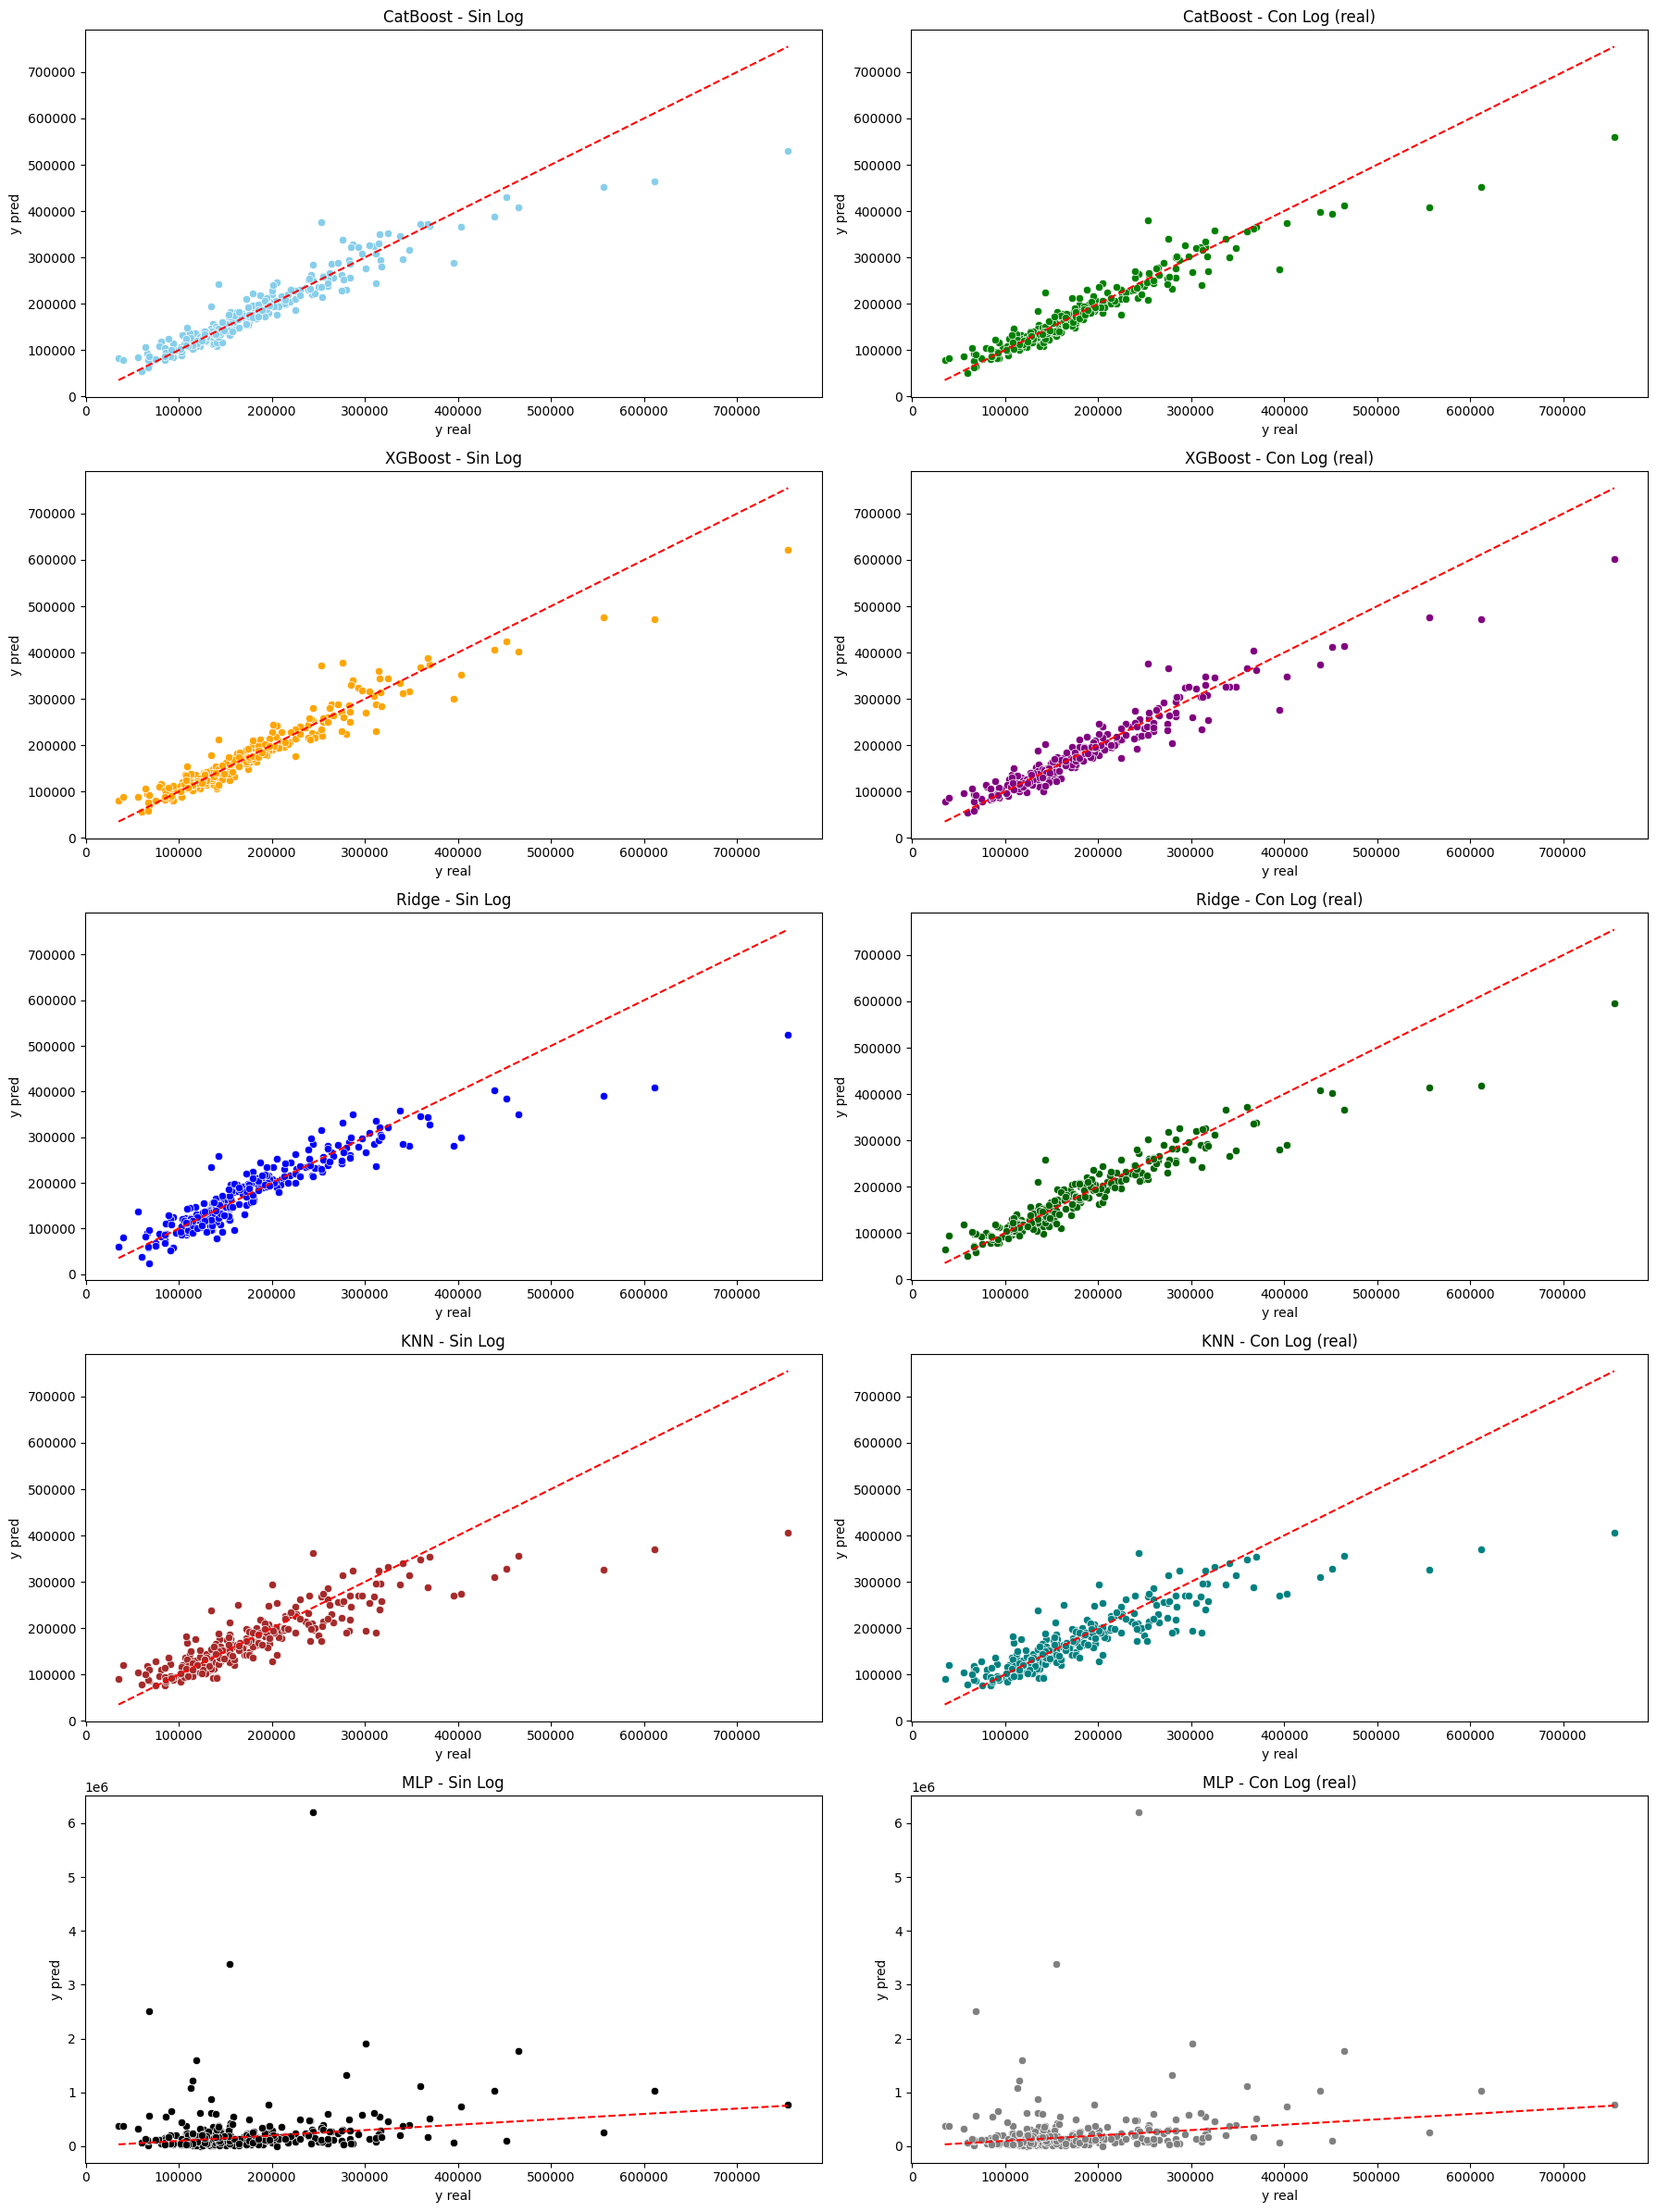

In [ ]:
# ============================================
#    PREDICCIONES VS VALORES REALES (TODOS)
# ============================================

plt.figure(figsize=(18, 24))


# ============================
# 1. CATBOOST
# ============================

# --- Sin log ---
plt.subplot(5, 2, 1)
sns.scatterplot(x=y_test_sinLog, y=y_pred_cb_base_sinLog, color='skyblue')
plt.plot([y_test_sinLog.min(), y_test_sinLog.max()],
         [y_test_sinLog.min(), y_test_sinLog.max()], 'r--')
plt.title("CatBoost - Sin Log")
plt.xlabel("y real")
plt.ylabel("y pred")

# --- Con log ---
plt.subplot(5, 2, 2)
sns.scatterplot(x=y_test_real , y=y_pred_cb_base_log, color='green')
plt.plot([y_test_real .min(), y_test_real .max()],
         [y_test_real .min(), y_test_real .max()], 'r--')
plt.title("CatBoost - Con Log (real)")
plt.xlabel("y real")
plt.ylabel("y pred")



# ============================
# 2. XGBOOST
# ============================

# --- Sin log ---
plt.subplot(5, 2, 3)
sns.scatterplot(x=y_test_sinLog, y=y_pred_xgb, color='orange')
plt.plot([y_test_sinLog.min(), y_test_sinLog.max()],
         [y_test_sinLog.min(), y_test_sinLog.max()], 'r--')
plt.title("XGBoost - Sin Log")
plt.xlabel("y real")
plt.ylabel("y pred")

# --- Con log ---
plt.subplot(5, 2, 4)
sns.scatterplot(x=y_test_real, y=test_pred, color='purple')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.title("XGBoost - Con Log (real)")
plt.xlabel("y real")
plt.ylabel("y pred")



# ============================
# 3. RIDGE REGRESSION
# ============================

# --- Sin log ---
plt.subplot(5, 2, 5)
sns.scatterplot(x=y_test_sinLog, y=y_pred_ridge, color='blue')
plt.plot([y_test_sinLog.min(), y_test_sinLog.max()],
         [y_test_sinLog.min(), y_test_sinLog.max()], 'r--')
plt.title("Ridge - Sin Log")
plt.xlabel("y real")
plt.ylabel("y pred")

# --- Con log ---
plt.subplot(5, 2, 6)
sns.scatterplot(x=y_test_real, y=y_pred_real, color='darkgreen')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.title("Ridge - Con Log (real)")
plt.xlabel("y real")
plt.ylabel("y pred")



# ============================
# 4. KNN
# ============================

# --- Sin log ---
plt.subplot(5, 2, 7)
sns.scatterplot(x=y_test_sinLog, y=y_pred_knn, color='brown')
plt.plot([y_test_sinLog.min(), y_test_sinLog.max()],
         [y_test_sinLog.min(), y_test_sinLog.max()], 'r--')
plt.title("KNN - Sin Log")
plt.xlabel("y real")
plt.ylabel("y pred")

# --- Con log ---
plt.subplot(5, 2, 8)
sns.scatterplot(x=y_test_real, y=y_pred_knn, color='teal')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.title("KNN - Con Log (real)")
plt.xlabel("y real")
plt.ylabel("y pred")



# ============================
# 5. MLP
# ============================

# --- Sin log ---
plt.subplot(5, 2, 9)
sns.scatterplot(x=y_test_sinLog, y=y_pred_test, color='black')
plt.plot([y_test_sinLog.min(), y_test_sinLog.max()],
         [y_test_sinLog.min(), y_test_sinLog.max()], 'r--')
plt.title("MLP - Sin Log")
plt.xlabel("y real")
plt.ylabel("y pred")

# --- Con log ---
plt.subplot(5, 2, 10)
sns.scatterplot(x=y_test_real, y=y_pred_test, color='gray')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.title("MLP - Con Log (real)")
plt.xlabel("y real")
plt.ylabel("y pred")


plt.tight_layout()
plt.show()


#**Reducción de dimensión**

##**Determinacion de variables de forma individual**

Se realizó un análisis individual de cada variable para evaluar su capacidad de explicar o predecir la variable objetivo (SalePrice). Para esto se usaron dos medidas:

Correlación (para variables numéricas): se calcula la correlación entre cada variable y la variable objetivo. Variables con correlación baja (cercana a 0) aportan poca información predictiva y son candidatas a eliminarse.

Información mutua (para todas las variables, incluyendo categóricas codificadas): mide cuánto aporta cada variable para reducir la incertidumbre sobre la variable objetivo. Valores bajos indican poca relevancia.

Se combinan los resultados de ambos métodos para generar un listado de variables candidatas a eliminar, que son aquellas con baja correlación o baja información mutua. Esto permite identificar características poco informativas y simplificar el modelo sin perder información relevante.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# Dataset y variable objetivo
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# =========================
# 1. Correlación para numéricas
# =========================
num_vars = X.select_dtypes(include=np.number).columns
correlations = X[num_vars].corrwith(y).sort_values(key=abs, ascending=False)

umbral_cor = 0.1
poco_informativas_num = correlations[abs(correlations) < umbral_cor]

# =========================
# 2. Información mutua para todas las variables codificadas
# =========================
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

umbral_mi = 0.01
poco_informativas = mi_scores[mi_scores < umbral_mi]

# =========================
# 3. Resumen de variables candidatas a eliminar
# =========================
candidatas = list(set(poco_informativas_num.index).union(set(poco_informativas.index)))
print("\nResumen de variables candidatas a eliminar:")
print(candidatas)

# =========================
# 4. Contar cuántas variables candidatas hay
# =========================
print("\nCantidad de variables candidatas a eliminar:", len(candidatas))



Resumen de variables candidatas a eliminar:
['Condition2', 'LandSlope', 'Heating', 'BsmtFinType1', 'MoSold', 'LandContour', 'OverallCond', 'Functional', 'YrSold', 'MSSubClass', 'Fence', 'BsmtFinSF2', 'LotConfig', 'BsmtCond', 'PoolArea', 'Condition1', 'SaleType', 'RoofMatl', 'Utilities', 'GarageQual', 'Street', 'BldgType', 'MiscVal', 'FireplaceQu', 'BsmtFinType2', 'BsmtHalfBath', 'ScreenPorch', 'LowQualFinSF', '3SsnPorch']

Cantidad de variables candidatas a eliminar: 29


##**Extraccíon de características lineal**

Se aplicó un análisis de componentes principales (PCA) con el objetivo de reducir la dimensionalidad del conjunto de datos sin perder información relevante. Primero se normalizaron todas las variables para que estuvieran en la misma escala y luego se realizó un PCA completo para revisar cuánta varianza explicaba cada componente. A partir de estos resultados, se decidió conservar los componentes necesarios para mantener al menos el 90% de la varianza total del conjunto de datos. Este criterio permitió reducir el número de variables manteniendo prácticamente la misma información útil. Finalmente, se obtuvo el conjunto reducido y se comparó cuántas columnas se conservaron y cuántas fueron eliminadas respecto a la versión original.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# 1. Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA sin límite para saber la varianza explicada
pca_temp = PCA()
pca_temp.fit(X_scaled)

# Varianza acumulada
varianza_acumulada = np.cumsum(pca_temp.explained_variance_ratio_)

# 3. Criterio: mantener componentes que expliquen el 90% de la varianza
num_componentes = np.argmax(varianza_acumulada >= 0.90) + 1

# 4. PCA final con ese número de componentes
pca_final = PCA(n_components=num_componentes)
X_reducido = pca_final.fit_transform(X_scaled)


total_original = X.shape[1]
total_nuevo = num_componentes
eliminadas = total_original - total_nuevo

print("Columnas originales:", total_original)
print("Columnas después del PCA:", total_nuevo)
print("Columnas eliminadas:", eliminadas)
print(f"Varianza explicada total: {varianza_acumulada[num_componentes-1]*100:.2f}%")


Columnas originales: 76
Columnas después del PCA: 49
Columnas eliminadas: 27
Varianza explicada total: 90.09%


##**Extracción de característícas no lineal**

Para complementar el análisis de reducción de dimensionalidad, se aplicó UMAP (Uniform Manifold Approximation and Projection) sobre los datos estandarizados, con el objetivo de obtener representaciones más compactas manteniendo su estructura interna.

Se ejecutaron UMAP con distintas dimensiones, incluyendo 2D, 3D y 10D. La versión de 10 dimensiones se utilizó para el entrenamiento de los modelos, ya que conserva la mayor parte de la información original (reducción menos agresiva, ~87 %–91 %) y permite maximizar el rendimiento predictivo, mientras que 2D y 3D se usaron principalmente para visualización.

###**DIMENCIONES**

#####**2D**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 2D: 2
Columnas eliminadas: 74
Reducción porcentual: 97.37%


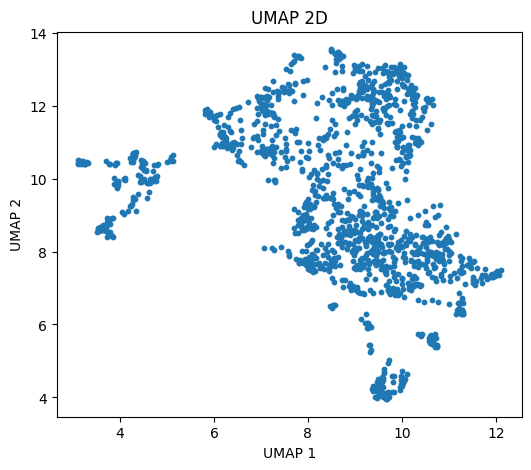

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 2D
reducer_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_2d = reducer_2d.fit_transform(X_scaled)

# DataFrame reducido
X_umap_2d_df = pd.DataFrame(X_umap_2d, columns=["UMAP_1", "UMAP_2"])

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_2d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 2D:", reduced_cols)
print("Columnas eliminadas:", eliminated)
print(f"Reducción porcentual: {pct_reduction:.2f}%")

# Gráfica 2D
plt.figure(figsize=(6, 5))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], s=10)
plt.title("UMAP 2D")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


#####**3D**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 3D: 3
Columnas eliminadas: 73
Reducción porcentual: 96.05%


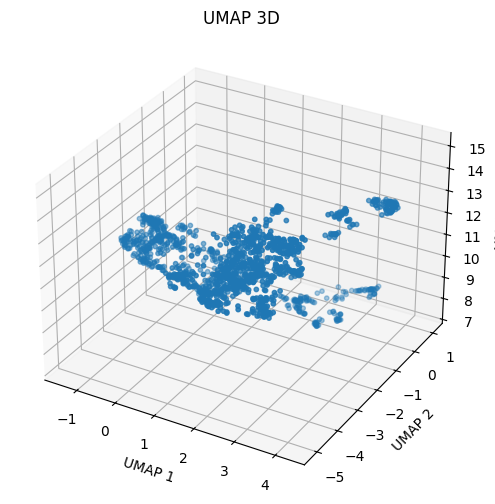

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 3D
reducer_3d = umap.UMAP(
    n_components=3,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_3d = reducer_3d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_3d_df = pd.DataFrame(X_umap_3d, columns=["UMAP_1_3D", "UMAP_2_3D", "UMAP_3_3D"])

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_3d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 3D:", reduced_cols)
print("Columnas eliminadas:", eliminated)
print(f"Reducción porcentual: {pct_reduction:.2f}%")

# Gráfica 3D
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2], s=10)
ax.set_title("UMAP 3D")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.show()


#####**4D**

In [ ]:
# UMAP 4D
reducer_4d = umap.UMAP(
    n_components=4,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_4d = reducer_4d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_4d_df = pd.DataFrame(X_umap_4d, columns=["UMAP_1_4D", "UMAP_2_4D", "UMAP_3_4D", "UMAP_4_4D"])

# Resumen de reducción
reduced_cols_4d = X_umap_4d_df.shape[1]
eliminated_4d = original_cols - reduced_cols_4d
pct_reduction_4d = (eliminated_4d / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 4D:", reduced_cols_4d)
print("Columnas eliminadas:", eliminated_4d)
print(f"Reducción porcentual: {pct_reduction_4d:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 4D: 4
Columnas eliminadas: 72
Reducción porcentual: 94.74%


#####**5D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 5D
reducer_5d = umap.UMAP(
    n_components=5,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_5d = reducer_5d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_5d_df = pd.DataFrame(
    X_umap_5d,
    columns=["UMAP_1_5D", "UMAP_2_5D", "UMAP_3_5D", "UMAP_4_5D", "UMAP_5_5D"]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_5d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 5D:", reduced_cols)
print("Columnas eliminadas:", eliminadas)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 5D: 5
Columnas eliminadas: 27
Reducción porcentual: 93.42%


####**6D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 6D
reducer_6d = umap.UMAP(
    n_components=6,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_6d = reducer_6d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_6d_df = pd.DataFrame(
    X_umap_6d,
    columns=[
        "UMAP_1_6D", "UMAP_2_6D", "UMAP_3_6D",
        "UMAP_4_6D", "UMAP_5_6D", "UMAP_6_6D"
    ]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_6d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 6D:", reduced_cols)
print("Columnas eliminadas:", eliminated)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 6D: 6
Columnas eliminadas: 70
Reducción porcentual: 92.11%


####**7D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 7D
reducer_7d = umap.UMAP(
    n_components=7,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_7d = reducer_7d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_7d_df = pd.DataFrame(
    X_umap_7d,
    columns=[
        "UMAP_1_7D", "UMAP_2_7D", "UMAP_3_7D",
        "UMAP_4_7D", "UMAP_5_7D", "UMAP_6_7D",
        "UMAP_7_7D"
    ]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_7d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 7D:", reduced_cols)
print("Columnas eliminadas:", eliminadas)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 7D: 7
Columnas eliminadas: 27
Reducción porcentual: 90.79%


####**8D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 8D
reducer_8d = umap.UMAP(
    n_components=8,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_8d = reducer_8d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_8d_df = pd.DataFrame(
    X_umap_8d,
    columns=[
        "UMAP_1_8D", "UMAP_2_8D", "UMAP_3_8D",
        "UMAP_4_8D", "UMAP_5_8D", "UMAP_6_8D",
        "UMAP_7_8D", "UMAP_8_8D"
    ]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_8d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 8D:", reduced_cols)
print("Columnas eliminadas:", eliminadas)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 8D: 8
Columnas eliminadas: 27
Reducción porcentual: 89.47%


####**9D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 9D
reducer_9d = umap.UMAP(
    n_components=9,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_9d = reducer_9d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_9d_df = pd.DataFrame(
    X_umap_9d,
    columns=[
        "UMAP_1_9D", "UMAP_2_9D", "UMAP_3_9D",
        "UMAP_4_9D", "UMAP_5_9D", "UMAP_6_9D",
        "UMAP_7_9D", "UMAP_8_9D", "UMAP_9_9D"
    ]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_9d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 9D:", reduced_cols)
print("Columnas eliminadas:", eliminadas)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 9D: 9
Columnas eliminadas: 27
Reducción porcentual: 88.16%


####**10D**

In [ ]:
!pip install umap-learn --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP 10D
reducer_10d = umap.UMAP(
    n_components=10,
    n_neighbors=30,
    min_dist=0.1,
    random_state=42
)

X_umap_10d = reducer_10d.fit_transform(X_scaled)

# DataFrame reducido con nombres diferenciados
X_umap_10d_df = pd.DataFrame(
    X_umap_10d,
    columns=[
        "UMAP_1_10D", "UMAP_2_10D", "UMAP_3_10D",
        "UMAP_4_10D", "UMAP_5_10D", "UMAP_6_10D",
        "UMAP_7_10D", "UMAP_8_10D", "UMAP_9_10D",
        "UMAP_10_10D"
    ]
)

# Resumen de reducción
original_cols = X.shape[1]
reduced_cols = X_umap_10d_df.shape[1]
eliminated = original_cols - reduced_cols
pct_reduction = (eliminated / original_cols) * 100

print("Columnas originales:", original_cols)
print("Columnas después de UMAP 10D:", reduced_cols)
print("Columnas eliminadas:", eliminadas)
print(f"Reducción porcentual: {pct_reduction:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Columnas originales: 76
Columnas después de UMAP 10D: 10
Columnas eliminadas: 27
Reducción porcentual: 86.84%


###**Evaluación**

Finalmente, se generaron los conjuntos transformados para cada caso y se calculó la reducción de variables, información que se empleará posteriormente para evaluar los modelos sobre el espacio reducido.

In [ ]:
X_train_10d, X_test_10d, y_train_10d, y_test_10d = train_test_split(X_umap_10d_df, y_sinLog, test_size=0.2, random_state=42)

####**CatBoost**

In [ ]:
# ------------------------------------------------------------------
# 1. Modelo base CatBoost
# ------------------------------------------------------------------
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=0
)

# ------------------------------------------------------------------
# 2. Validación cruzada
# ------------------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_pred = cross_val_predict(model, X_train_10d, y_train_10d, cv=kfold)

rmse_cv = np.sqrt(mean_squared_error(y_train_10d, cv_pred))
mae_cv  = mean_absolute_error(y_train_10d, cv_pred)
r2_cv   = r2_score(y_train_10d, cv_pred)

print("Validación Cruzada - CatBoost (UMAP 10D, sin log):")
print(f"RMSE CV: {rmse_cv:.4f}")
print(f"MAE CV:  {mae_cv:.4f}")
print(f"R² CV:   {r2_cv:.4f}")

# ------------------------------------------------------------------
# 3. Entrenamiento final
# ------------------------------------------------------------------
model.fit(X_train_10d, y_train_10d)

# ------------------------------------------------------------------
# 4. Evaluación en test
# ------------------------------------------------------------------
y_pred = model.predict(X_test_10d)

rmse_test = np.sqrt(mean_squared_error(y_test_10d, y_pred))
mae_test  = mean_absolute_error(y_test_10d, y_pred)
r2_test   = r2_score(y_test_10d, y_pred)

print("\nEvaluación Final en Test - CatBoost (UMAP 10D, sin log):")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")
print(f"R²:   {r2_test:.4f}")


Validación Cruzada - CatBoost (UMAP 10D, sin log):
RMSE CV: 41457.4453
MAE CV:  25521.4645
R² CV:   0.7118

Evaluación Final en Test - CatBoost (UMAP 10D, sin log):
RMSE: 47146.6549
MAE:  27357.1966
R²:   0.7102


####**XGBoost**

In [ ]:
# ------------------------------------------------------------------
# 2. Definir modelo base XGBoost
# ------------------------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# ------------------------------------------------------------------
# 3. Validación Cruzada (UMAP 10D, sin log)
# ------------------------------------------------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_pred = cross_val_predict(xgb_model, X_train_10d, y_train_10d, cv=kfold)

rmse_cv_xgb = np.sqrt(mean_squared_error(y_train_10d, cv_pred))
mae_cv_xgb  = mean_absolute_error(y_train_10d, cv_pred)
r2_cv_xgb   = r2_score(y_train_10d, cv_pred)

print("Validación Cruzada - XGBoost (UMAP 10D, sin log):")
print(f"RMSE CV: {rmse_cv_xgb:.4f}")
print(f"MAE CV:  {mae_cv_xgb:.4f}")
print(f"R² CV:   {r2_cv_xgb:.4f}")

# ------------------------------------------------------------------
# 4. Entrenamiento final con todo el train
# ------------------------------------------------------------------
xgb_model.fit(X_train_10d, y_train_10d)

# ------------------------------------------------------------------
# 5. Evaluación en test
# ------------------------------------------------------------------
y_pred_xgb = xgb_model.predict(X_test_10d)

rmse_xgb = np.sqrt(mean_squared_error(y_test_10d, y_pred_xgb))
mae_xgb  = mean_absolute_error(y_test_10d, y_pred_xgb)
r2_xgb   = r2_score(y_test_10d, y_pred_xgb)

print("\nEvaluación Final en Test - XGBoost (UMAP 10D, sin log):")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")
print(f"R²:   {r2_xgb:.4f}")


Validación Cruzada - XGBoost (UMAP 10D, sin log):
RMSE CV: 41960.4370
MAE CV:  26191.2539
R² CV:   0.7048

Evaluación Final en Test - XGBoost (UMAP 10D, sin log):
RMSE: 46725.1038
MAE:  27107.4043
R²:   0.7154
